## Set GPU using tensorflow

In [1]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

## Define Keras Model

In [2]:
from keras.layers import Dense,CuDNNLSTM,CuDNNGRU

Using TensorFlow backend.


In [3]:
import matlab.engine
from datetime import datetime
import tensorflow as tf
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Input,Dense, Dropout, BatchNormalization, Activation
from keras import backend as K
from keras.callbacks import Callback
#from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import optimizers
#from sklearn import linear_model
#from sklearn import preprocessing
import matplotlib.pyplot as plt
#from sklearn.utils import shuffle
from tensorflow import keras
import time
from sklearn.metrics import r2_score
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

In [4]:
iteration=0
no_of_sources=1
batch_size=1
samples_per_snr=1000
weight_file="layers_2_64"

In [5]:
def matToPyReshape(matArray):
    pyArray=np.zeros((samples_per_snr,16,10))
    for i in range(0,samples_per_snr):
        C=matArray[0,:,i]
        for j in range(1,16):
            C=np.column_stack((C,matArray[j,:,i]))
        pyArray[i,:]=C.T
    return pyArray
    

#### Define a checkpoint callback:

In [6]:
def r_m_s_e(y_true, y_pred):
        print(K.int_shape(y_pred))
   # if no_of_sources==1:
   #     return K.sqrt(K.mean(K.square(K.abs(y_pred-y_true)))) 
   # else:
        total=no_of_sources*batch_size
        
        b=K.repeat_elements(y_true,no_of_sources,axis=0)
        print("b ",K.int_shape(b))
        c=K.repeat_elements(y_pred,no_of_sources,axis=1)
        print(K.int_shape(c))
        c=K.reshape(c,(total,no_of_sources))
        print(K.int_shape(c))
        d=b-c
        print(K.int_shape(d))
        d=K.abs(d)
        mini1=K.min(d,axis=1)
        print(K.int_shape(mini1))
        mini1=K.reshape(mini1,(batch_size,no_of_sources))
        print(K.int_shape(mini1)) 
        return K.sqrt(K.mean(K.square(mini1),axis=-1))

In [7]:
#checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint_name1 = weight_file
checkpoint1 = ModelCheckpoint(checkpoint_name1, monitor="loss", verbose = 1, save_best_only = False, mode ='auto')



In [8]:
#X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

###  Batch normalization after a  & dr1=0.01 dr2=0.1

In [9]:
eng = matlab.engine.start_matlab()

In [10]:
rate=0.001
model = Sequential()
dr=0
#model.add(RepeatVector(16,input_shape=(256,)))

model.add(CuDNNLSTM(128,return_sequences=True,kernel_initializer="glorot_normal",input_shape=(10,32)))
model.add(Dropout(dr))
#model.add(BatchNormalization())
model.add(CuDNNLSTM(128,return_sequences=False,kernel_initializer="glorot_normal"))
model.add(Dropout(dr))
#model.add(BatchNormalization())
#model.add(Dropout(dr))

model.add(Dense(no_of_sources, kernel_initializer='he_normal'))
adam=optimizers.Adam(lr=rate)
model.compile(optimizer=adam, loss="mean_absolute_error", metrics=["mean_absolute_error"])

model.load_weights(weight_file)
callbacks_list = [checkpoint1]
#model.compile(loss='categorical_crossentropy',
              #optimizer='adam', metrics=["accuracy"])


W0912 12:43:03.309762 140574877312768 deprecation_wrapper.py:119] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0912 12:43:03.312941 140574877312768 deprecation_wrapper.py:119] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0912 12:43:03.646119 140574877312768 deprecation_wrapper.py:119] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0912 12:43:03.818570 140574877312768 deprecation_wrapper.py:119] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Ple

In [11]:
def Signal_gen(snr):
    X_real, X_imag, label =eng.doa(snr,samples_per_snr,no_of_sources,nargout=3)
    X_real=np.asarray(X_real)
    X_imag=np.asarray(X_imag)
    label=np.asarray(label)
    a=matToPyReshape(X_real)
    b=matToPyReshape(X_imag)
    X_real_imag=np.zeros((samples_per_snr,32,10))
    for j in range(samples_per_snr):
        X_real_imag[j,]=np.concatenate((a[j,],b[j,]),axis=0)
        
    m=np.zeros((X_real_imag.shape[0],X_real_imag.shape[2],X_real_imag.shape[1]))
    for i in range(X_real_imag.shape[0]):
        for j in range(X_real_imag.shape[2]):
            m[i,j,:]=X_real_imag[i,:,j]
    X_real_imag=m
    
    #PREPROCESSING
    scaler = MinMaxScaler()
    for k in range(X_real_imag.shape[0]):
        X_real_imag[k,:,:]=scaler.fit_transform(X_real_imag[k,:,:])
    return X_real_imag,label

In [ ]:
#SNRs=[10.0,15.0,20.0,25.0]
SNRs=[10.0,15.0,20.0,25.0]
while True:
    X_train, y_train=Signal_gen(5.0)
    for snr in SNRs:
        X, y=Signal_gen(snr)
        X_train=np.vstack((X_train,X))
        y_train=np.vstack((y_train,y))
    model.fit(X_train,y_train,epochs=1,callbacks=callbacks_list,verbose=1,batch_size=batch_size,shuffle=False)
    iteration=iteration+1
    print(iteration)

### Evaluate the results

In [12]:
model.load_weights(weight_file)

In [13]:
samples_per_snr=50000

In [14]:
SNRs=[5.0,10.0,15.0,20.0,25.0]
b1=np.zeros((5,))
b2=np.zeros((5,))
i=0
for snr in SNRs:
        X_test, y_test=Signal_gen(snr)
        b1[i]=model.evaluate(X_test,y_test,verbose=0,batch_size=batch_size)[0]
        i=i+1

In [15]:
b1

array([4.43216945, 3.71509476, 3.14285833, 3.06905892, 3.08226219])

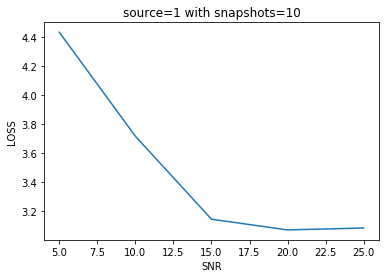

In [17]:
x = np.linspace(5, 25, 5)

plt.plot(x, b1, label='linear')

plt.title('source=1 with snapshots=10')
plt.ylabel('LOSS')
plt.xlabel('SNR')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
model.save_weights("weight_initialization_sir.hdf5")

In [ ]:
#SNRs=[10.0,15.0,20.0,25.0]
SNRs=[5.0,10.0,15.0,20.0,25.0]
while True:
    for snr in SNRs:
        X, y=Signal_gen(snr)
        loss=model.train_on_batch(X, y)
        print(loss)
    iteration=iteration+1
    print(iteration)

In [ ]:
model.evaluate(X_test[60000:],Y_test[60000:], verbose=0)[0]

In [ ]:
def r_m_s_e(y_true, y_pred):
        print(K.int_shape(y_pred))
   # if no_of_sources==1:
   #     return K.sqrt(K.mean(K.square(K.abs(y_pred-y_true)))) 
   # else:
        total=no_of_sources*batch_size
        
        b=K.repeat_elements(y_true,no_of_sources,axis=0)
        print("b ",K.int_shape(b))
        c=K.repeat_elements(y_pred,no_of_sources,axis=1)
        print(K.int_shape(c))
        c=K.reshape(c,(total,no_of_sources))
        print(K.int_shape(c))
        d=b-c
        print(K.int_shape(d))
        d=K.abs(d)
        mini1=K.min(d,axis=1)
        print(K.int_shape(mini1))
        mini1=K.reshape(mini1,(batch_size,no_of_sources))
        print(K.int_shape(mini1))
        
        return K.sqrt(K.mean(K.square(mini1),axis=-1)) 

In [ ]:
with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['r_m_s_e'])
plt.plot(history.history['val_r_m_s_e'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
a=np.arange(24)
a

In [ ]:
a=a.reshape((4,3,2))
a

In [ ]:
b=np.zeros((4,3))

In [ ]:
for i in range(4):
    b[i,]=a[i,:,0]

In [ ]:
b

In [ ]:
a=b

In [ ]:
a

In [ ]:
a[2:]

In [ ]:
from sklearn.utils import shuffle
import numpy as np

X = np.array([[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4]])
y = np.array([0, 1, 2, 3, 4])
y=y.reshape((5,1))
X, y = shuffle(X, y)
print(X)
print(y)



In [ ]:
import numpy as np

In [ ]:
X1=np.arange(24)

In [ ]:
X1

In [ ]:
X1=X1.reshape((4,3,2))

In [ ]:
X1

In [ ]:
m=np.zeros((X1.shape[0],X1.shape[2],X1.shape[1]))
for i in range(X1.shape[0]):
    for j in range(X1.shape[2]):
        m[i,j,:]=X1[i,:,j]

In [ ]:
X1=m

In [ ]:
X2=np.arange(24,48)

In [ ]:
X2.shape

In [ ]:
X2=X2.reshape((4,2,3))

In [ ]:
X2

In [ ]:
c=np.vstack((X1,X2))
c.shape

In [ ]:
c

In [ ]:
import numpy as np

In [ ]:
a=np.array([1,2])

In [ ]:
a

In [ ]:
y_pred=K.variable([[1,2,11,30]])
y_true=K.variable([[10,11,30,50]])

In [ ]:
z=K.variable([[y_true[0]-y_pred[0],  y_true[0]-y_pred[1],  y_true[0]-y_pred[2],  y_true[0]-y_pred[3]]])

In [ ]:
K.eval(y_true)

In [ ]:
top=2
y_pred, y_pred_ind_k = tf.nn.top_k(y_pred, top)
y_true, y_true_ind_k = tf.nn.top_k(y_true, top)

In [ ]:
K.eval(y_pred)

In [ ]:
y_true, y_true_ind_k = tf.nn.top_k(y_true, top)

In [ ]:
K.eval(y_true)

In [ ]:
np_y_pred=np.array([1,2,11,30])
np_y_true=np.array([10,11,30,50])

In [ ]:
c=np.zeros((4,))

In [ ]:
one_sided=helper(np_y_pred,np_y_true)
two_sided=helper(np_y_true,np_y_pred)

In [ ]:
one_sided

In [ ]:
two_sided

In [ ]:
combined=np.concatenate([one_sided,two_sided])

In [ ]:
combined

In [ ]:
for i in range(0,4):
    for j in range(0,4):
        a=abs(np_y_true[j]-np_y_pred[i])
        print(a)
        b[j]=a
    c[i]=min(b)

In [ ]:
c

In [ ]:
ker=K.variable(value=combined)

In [ ]:
K.eval(K.sqrt(K.mean(K.square(ker))) )

In [ ]:
K.eval(ker)

In [ ]:
d=K.eval(ker)

In [ ]:
d

In [ ]:
X_real, X_imag, label =eng.Copy_of_doa(5.0,nargout=3)
X_real=np.asarray(X_real)
X_imag=np.asarray(X_imag)
label=np.asarray(label)

In [ ]:
label.shape

In [ ]:
X_real.shape

In [ ]:
y_pred=np.array([[1,2,11,30],
                 [3,4,9,10]])
y_true=np.array([[10,11,30,50],
                 [9,10,11,12]])
y_pred.shape

In [ ]:
y_pred=y_pred.reshape((2,1,4))
y_pred

In [ ]:
one=np.ones((2,4,1))

In [ ]:
b=np.dot(one,y_pred, axes=1)

In [ ]:
b.shape

In [ ]:
b

In [ ]:
a=np.array([[1,2,11,30], [1,2,4,5]])

In [ ]:
b = np.repeat(a, 4, axis=0)

In [ ]:
b

In [ ]:
c=np.array([[10,11,30,50], [5,4,9,10]])

In [ ]:
c=np.array([[10,11,30,50], [5,4,9,10]])
c = np.repeat(c, len(c[0]), axis=1)
print(c)
print(c.shape)

c = c.reshape(8, 4)
print(c)

In [ ]:
d=np.subtract(b,c)

In [ ]:
d=np.abs(d)

In [ ]:
d

In [ ]:
mini=np.min(d, axis=1)

In [ ]:
mini=mini.reshape(2,4)

In [ ]:
mini

In [ ]:
d=d.reshape(2,4,4)

In [ ]:
d

In [ ]:
mini=np.min(d, axis=1)
mini

In [ ]:
no_of_sources=2
batch_size=4

In [ ]:
def r_m_s_e(y_true, y_pred):
        print(K.int_shape(y_pred))
   # if no_of_sources==1:
   #     return K.sqrt(K.mean(K.square(K.abs(y_pred-y_true)))) 
   # else:
        total=no_of_sources*batch_size
        
        b=K.repeat_elements(y_true,no_of_sources,axis=0)
        print("b ",K.int_shape(b))
        c=K.repeat_elements(y_pred,no_of_sources,axis=1)
        print(K.int_shape(c))
        c=K.reshape(c,(total,no_of_sources))
        print(K.int_shape(c))
        d=b-c
        print(K.int_shape(d))
        d=K.abs(d)
        mini1=K.min(d,axis=1)
        print(K.int_shape(mini1))
        mini1=K.reshape(mini1,(batch_size,no_of_sources))
        print(K.int_shape(mini1))
        
        return K.sqrt(K.mean(K.square(mini1),axis=-1)) 

In [ ]:
y_true = K.variable([[10,5],
                    [9,3],
                    [8,7],
                    [6,5]])
y_pred = K.variable([[8,9],
                    [8,4],
                    [9,10],
                    [14,15]])
#Aloss=r_m_s_e(y_true,y_pred)
#print(K.eval(loss))


In [ ]:
K.eval(r_m_s_e(y_true,y_pred))

In [ ]:
y_true.shape

In [ ]:
def mean_np(y_true,y_pred):
    return np.mean(np.square((y_pred-y_true)))

In [ ]:
def mean_squared_error_k(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [ ]:
K.eval(mean_squared_error_k(y_true,y_pred))

In [ ]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred-y_true),axis = -1)

In [ ]:
loss=mean_squared_error(y_true,y_pred)
print(K.eval(loss))


In [ ]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

In [ ]:
y=mean_squared_error(y_true,y_pred)

In [ ]:
y.shape

In [ ]:
K.eval(y)